In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import git
import seaborn as sns
%matplotlib inline

from glob import glob
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
repo_url = "https://github.com/roneysco/Fake.br-Corpus.git"

if not os.path.exists("fake_br"):
    repo = git.Repo.clone_from(repo_url, "fake_br")

In [4]:
folder = r'fake_br/full_texts/'

In [5]:
def extract_data(data_path, label):
    dir_data = glob(data_path)
    array = []

    # Capturando dados das notícias
    for path in tqdm(dir_data):
        file = open(path, encoding = 'utf-8')
        text = file.readlines()
        text = ' '.join(text)
        content = [text, label]
        file.close()
        array.append(content)   
         
    return np.array(array)

In [6]:
dir_meta_fake = glob(folder + 'fake-meta-information\*.txt')
dir_meta_true = glob(folder + 'true-meta-information\*.txt')

In [7]:
def read_metadata(dir, label):    
    metadata = []
    
    for path in dir:
        data = np.genfromtxt(path, delimiter = '\n', dtype = str, encoding = 'utf-8')
        if len(data) < 25:
            # print(path)
            data = np.insert(data, 0, None)
        metadata.append(data)

    metadata = np.array(metadata)
    metadata = np.c_[metadata, [label for i in range(len(metadata))]]
    
    return metadata

In [8]:
meta_fake = read_metadata(dir_meta_fake, 'fake')
meta_true = read_metadata(dir_meta_true, 'true')
metadata = np.concatenate((meta_fake, meta_true), axis = 0)

In [9]:
columns = ['author', 'link', 'category', 'date', 'tokens', 'words', 'types', 'links', 'upper_case', 'verbs', 'subj_imp_verbs', 
           'nouns', 'adjectives', 'adverbs', 'modal_verbs', 'sing_first_sec_pers_pronouns', 'plural_first_pers_pronouns', 
           'pronouns', 'pausality', 'characters', 'average_sent_length', 'average_word_length', 'news_with_speeling_errors', 
           'emotiveness', 'diversity', 'label']

In [10]:
meta_df = pd.DataFrame(metadata, columns = columns)
meta_df.head()

,author,link,category,date,tokens,words,types,links,upper_case,verbs,...,plural_first_pers_pronouns,pronouns,pausality,characters,average_sent_length,average_word_length,news_with_speeling_errors,emotiveness,diversity,label
0,mrk,https://ceticismopolitico.com/2017/11/30/katia...,politica,2017-11-30,211,185,120,0,6,30,...,0,26,2.0,815,14.2308,4.40541,0.0,0.263158,0.648649,fake
1,None,https://ceticismopolitico.com/2017/11/24/dr-ra...,politica,2017-11-24,289,254,163,0,0,56,...,0,20,2.5,1205,18.1429,4.74409,0.00787402,0.241667,0.641732,fake
2,None,https://afolhabrasil.com.br/politica/reinaldo-...,politica,2017-05-23,304,275,170,0,0,45,...,0,18,1.8125,1344,17.1875,4.88727,0.00363636,0.12782,0.618182,fake
3,None,https://www.diariodobrasil.org/relatorio-assus...,politica,24/07/2017,639,572,316,1,14,87,...,0,34,2.68,3122,22.88,5.45804,0.00174825,0.229008,0.552448,fake
4,None,https://www.diariodobrasil.org/radialista-amer...,politica,25/07/2017,128,111,82,0,1,21,...,0,12,0.894737,515,5.84211,4.63964,0.0,0.269231,0.738739,fake


In [11]:
meta_df = meta_df.replace('None', np.nan)
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   author                        3599 non-null   object
 1   link                          7200 non-null   object
 2   category                      7200 non-null   object
 3   date                          7200 non-null   object
 4   tokens                        7200 non-null   object
 5   words                         7200 non-null   object
 6   types                         7200 non-null   object
 7   links                         5807 non-null   object
 8   upper_case                    7200 non-null   object
 9   verbs                         7200 non-null   object
 10  subj_imp_verbs                7200 non-null   object
 11  nouns                         7200 non-null   object
 12  adjectives                    7200 non-null   object
 13  adverbs           

In [12]:
print(meta_df['author'].value_counts())

Por G1                                                                                                    331
Por BBC                                                                                                   235
José Nêumanne                                                                                             173
Por G1, Brasília                                                                                           86
O Estado de S.Paulo                                                                                        71
                                                                                                         ... 
Carla Araújo e Tânia MonteiroBRASÍLIA                                                                       1
Por Amanda Polato, Adriana Justi, Bibiana Dionísio e Fernando Castro, G1 e G1 PR, São Paulo e Curitiba      1
Lúcia Guimarães, Impresso                                                                                   1
Stéfanie P

In [13]:
meta_df = meta_df.drop(columns = ['author', 'link', 'date', 'category', 'adverbs', 'plural_first_pers_pronouns',
                                  'average_word_length', 'sing_first_sec_pers_pronouns', 'news_with_speeling_errors',
                                  'average_sent_length', 'adjectives', 'tokens', 'words'])
meta_df.head()

,types,links,upper_case,verbs,subj_imp_verbs,nouns,modal_verbs,pronouns,pausality,characters,emotiveness,diversity,label
0,120,0,6,30,1,46,5,26,2.0,815,0.263158,0.648649,fake
1,163,0,0,56,8,64,11,20,2.5,1205,0.241667,0.641732,fake
2,170,0,0,45,1,88,8,18,1.8125,1344,0.12782,0.618182,fake
3,316,1,14,87,7,175,14,34,2.68,3122,0.229008,0.552448,fake
4,82,0,1,21,0,31,1,12,0.894737,515,0.269231,0.738739,fake


In [14]:
X, y = meta_df.iloc[:, :-1], meta_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 42, 
                                                    test_size = 0.2, 
                                                    stratify = y)

In [15]:
# X1 = X.iloc[:, 1]
# # X2 = X.iloc[:, 21]

# # plt.plot(X2, X2, '*')
# for x1, label in zip(X1, y):
#     if label == 'fake':
#         plt.plot(x1, x1, 'b*')
#     else:
#         plt.plot(x1, x1, 'r*')
# plt.xscale('linear')
# plt.yscale('linear')
# plt.xlabel('Tokens')
# plt.ylabel('Palavras')

In [16]:
def imputer(train, test):
    simple_imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 0.0)
    transf_train = simple_imputer.fit_transform(train.ravel().reshape([len(train), 1]))
    transf_test = simple_imputer.transform(test.ravel().reshape([len(test), 1]))

    return transf_train, transf_test

for column in X_train:
    X_train[column], X_test[column] = imputer(X_train[column], X_test[column])

In [17]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_train, y_test = y_train.reshape(-1), y_test.reshape(-1)

In [18]:
mm = MinMaxScaler()

X_train = mm.fit_transform(X_train)
X_test = mm.transform(X_test)

In [19]:
model = SVC(kernel = 'poly')
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9756944444444444

<AxesSubplot: >

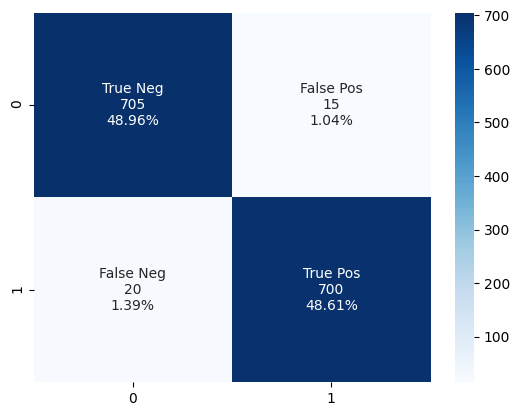

In [20]:
cm = confusion_matrix(y_test, model.predict(X_test))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                    cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

In [21]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       720
           1       0.98      0.97      0.98       720

    accuracy                           0.98      1440
   macro avg       0.98      0.98      0.98      1440
weighted avg       0.98      0.98      0.98      1440



In [22]:
# def f_importances(coef, names):
#     imp = coef
#     imp, names = zip(*sorted(zip(imp, names)))
#     plt.barh(range(len(names)), imp, align='center')
#     plt.yticks(range(len(names)), names)
#     plt.show()

# features = ['types', 'links', 'upper_case', 
#             'verbs', 'subj_imp_verbs', 'nouns',
#             'modal_verbs', 'pronouns', 'pausality',
#             'characters', 'emotiveness', 'diversity']

# f_importances(model.coef_[0], features)